### Preprocessing - Skewness Correction - Computer Vision Approach

*This module is designed to correct skewness using OpenCV Libraries*

Approach
* Edge Detection
* Hough Transformation
* Correct the document with the most contributing angle


For this purpose, I have used a publicly available Kaggle dataset ("Noisy and Rotated Scanned Documents"). The objective of choosing this dataset is because it has labelled data. I want to use supervised CNN for detecting angles and eventually compare the accuracy with the computer vision approach. Finally, all models will be applied to Input Data created using Course Descriptor.

### Connect to Google Drive

Google drive contains the input data created using Course Descriptor

In [1]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
## Load all ipynb files from Google Drive to Colab environment
import os
import shutil

def find_and_copy_files(src_folder, dest_folder, file_extension):
    for foldername, subfolders, filenames in os.walk(src_folder):
        for filename in filenames:
            if filename.endswith(file_extension):
                src_file = os.path.join(foldername, filename)
                dest_file = os.path.join(dest_folder, filename)
                try:
                    shutil.copy2(src_file, dest_file)  # Use shutil.copy if you don't need metadata
                    print(f"Copied: {src_file} to {dest_file}")
                except Exception as e:
                    print(f"Error copying {src_file}: {e}")

In [3]:
src_folder = '/content/gdrive/MyDrive/OWR/source'
dest_folder = '/content'
file_extension = '.ipynb'

# Call the function to find and copy files
find_and_copy_files(src_folder, dest_folder, file_extension)

Copied: /content/gdrive/MyDrive/OWR/source/input_generator/owr_input_generator.ipynb to /content/owr_input_generator.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/owr_model_v2.ipynb to /content/owr_model_v2.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/owr_segmentation_v3.ipynb to /content/owr_segmentation_v3.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_classification.ipynb to /content/owr_preprocess_skew_CNN_classification.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_regression.ipynb to /content/owr_preprocess_skew_CNN_regression.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_cv.ipynb to /content/owr_preprocess_skew_cv.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocessing.ipynb to /content/owr_preprocessing.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocess

### Load Data from Kaggle

In [ ]:
# Note that Kaggle dataset is already loaded into G Drive
# Therefore, following code segment is not required

#!pip install opendatasets
#import opendatasets as od

#od.download("https://www.kaggle.com/datasets/sthabile/noisy-and-rotated-scanned-documents?select=scan_doc_rotation")

## Import Packages/Modules from Colab Environment

In [4]:
!pip install import_ipynb
import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


### Import Libraries

In [5]:
import os
import json
import random
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.feature import canny
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from scipy.stats import mode

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Import Colab Models
import owr_pre_skew_cv_base as SkewCV

importing Jupyter notebook from owr_pre_skew_cv_base.ipynb


### Global Parameters

In [6]:
# Global Parameters

# Kaggle dataset parameters
root = '/content/gdrive/MyDrive/OWR/data/Kaggle/noisy-and-rotated-scanned-documents/scan_doc_rotation'
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')
tilted_root = '/content/gdrive/MyDrive/OWR/data/Kaggle/noisy-and-rotated-scanned-documents-tilted/scan_doc_rotation'
tilted_T_image_paths = os.path.join(tilted_root, 'images_T')
tilted_image_paths = os.path.join(tilted_root, 'images')

# Course Descriptor Parameters
input_path = '/content/gdrive/MyDrive/OWR/data/input'
tmp_input_path = '/content/gdrive/MyDrive/OWR/data/tmp_input'
tmp_tilt_path = '/content/gdrive/MyDrive/OWR/data/tmp_tilt'
tmp_skewed_path = '/content/gdrive/MyDrive/OWR/data/tmp_skewed'
start_page = 39
end_page   = 130
angle_range = (-5, 5)
shear_values=(-0.2, -0.1, 0, 0.1, 0.2)
csv_file_name = 'input.csv'

### Load Test and Train image name from json file




In [7]:
# Test List
test_list_path = os.path.join(root, 'test_list.json')

with open(test_list_path) as f:
    test_list = json.load(f)

In [8]:
# Train List
train_list_path = os.path.join(root, 'train_list.json')

with open(train_list_path) as f:
    train_list = json.load(f)

label_list = [x.split('.')[0] + '.txt' for x in train_list]

### Load few random image from training dataset

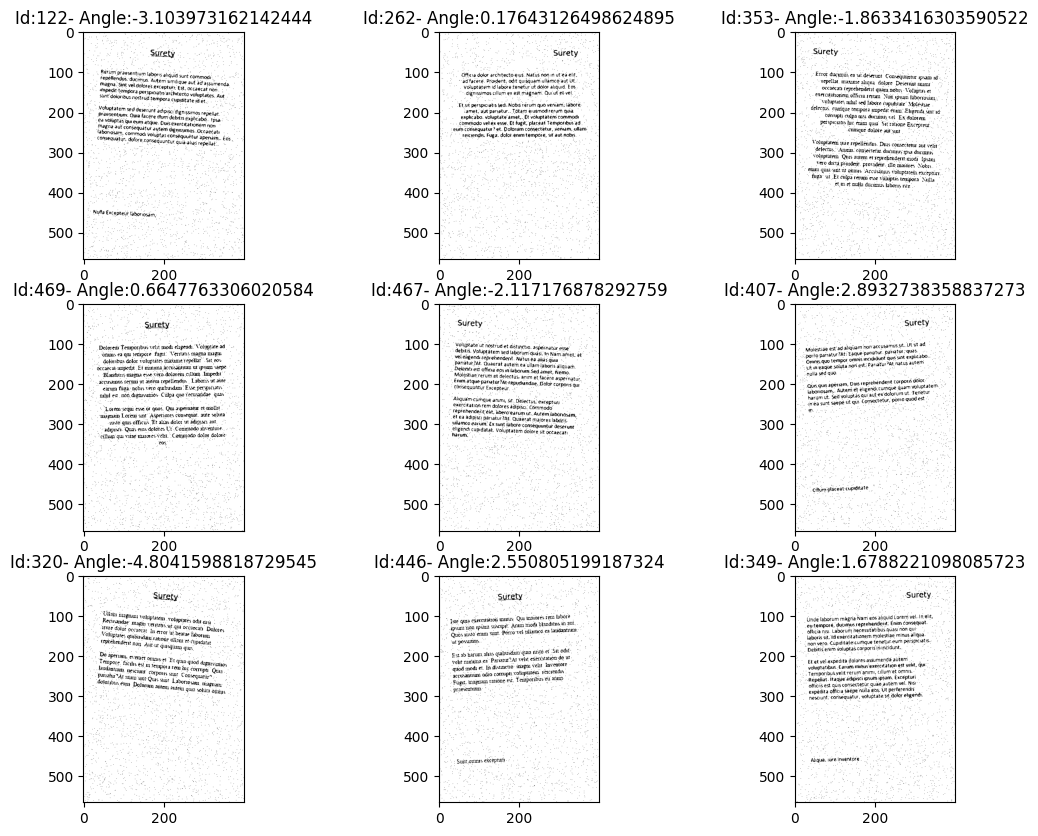

In [9]:
# Display random images
plt.figure(figsize=(13,10))
for i in range(9):
  id, sample_image_path, sample_label_path = SkewCV.get_random_img(image_paths, label_paths, train_list, label_list)

  # writes id and angle of sample in output
  with open(sample_label_path) as f:
    angle = f.read()

  sample_title = "Id:" + str(id) + '- Angle:' + angle

  #sample_tile = 'Label: Angle ' + str(np.round(float(angle),1))

  ax = plt.subplot(3, 3, i+1)
  img, title = SkewCV.display_image(sample_image_path, sample_title)
  plt.imshow(img, cmap='gray');
  plt.title(title)



### Apply Hough Transform
Steps
* Read image as gray scale
* Use canny edge detector
* Customize the range of angles
* Detect all lines on the image
* Get most prominent lines separated by a certain angle
* Vote among angles of the prominent lines

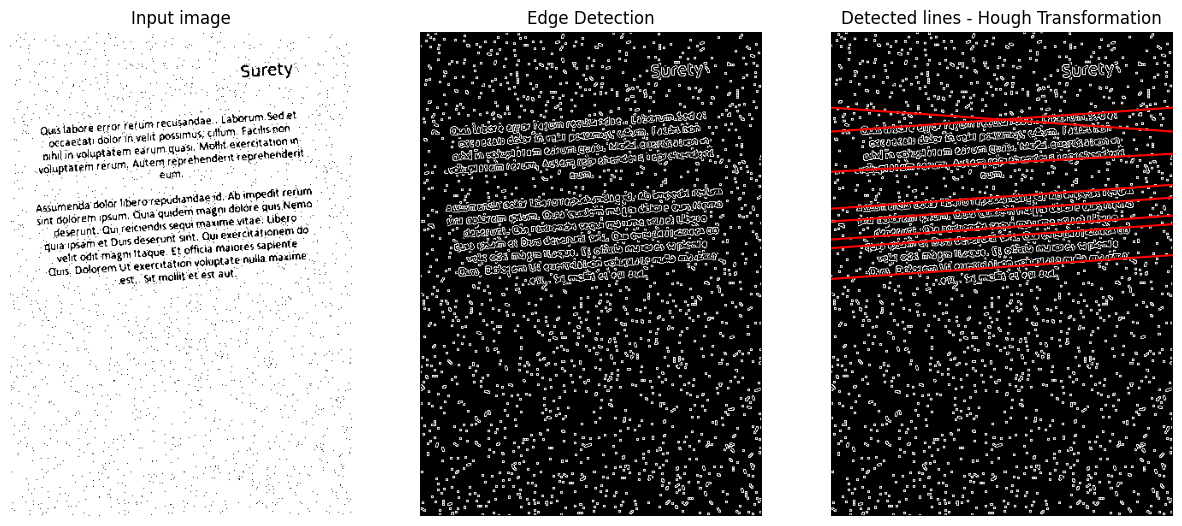

Predicted Angle 86.0, fixed angle -4.0
Original Angle: 3.684375124352501


In [10]:
eg_img = os.path.join(image_paths, train_list[15])
eg_img_lbl = os.path.join(label_paths, label_list[15])
image, edges, y, angle, fixed_angle = SkewCV.display_Hough_Transform(eg_img, angle_range, 1.0)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()


ax[1].imshow(edges, cmap="gray")
ax[1].set_title('Edge Detection')
ax[1].set_axis_off()

ax[2].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for y0, y1  in y:
  ax[2].plot(origin, (y0, y1), '-r')

ax[2].set_xlim(origin)
ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines - Hough Transformation')
plt.show()


print(f"Predicted Angle {angle}, fixed angle {fixed_angle:.2}")
print(f"Original Angle: {open(eg_img_lbl).read()}")

Text(0.5, 1.0, 'fixed angle:-4.0')

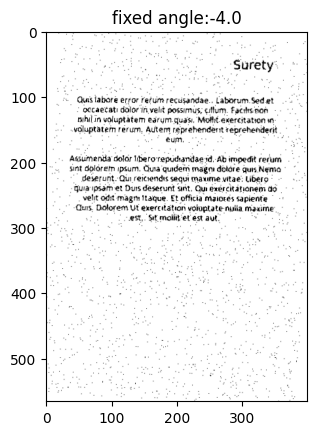

In [11]:
corrected_img, title = SkewCV.display_corrected_img(eg_img, 'fixed angle:' + str(fixed_angle), fixed_angle )

#plt.imshow(corrected_image, cmap='gray');
plt.imshow(corrected_img);
plt.title(title)

In [9]:
M = len(label_list)
labels =  [ np.loadtxt(os.path.join(label_paths ,label_list[j])) for j in range(M) ]

# Load first 10 labels
[print(labels[i]) for i in range(5)]
print('Total number of labels %d'%len(labels))

-0.337673521065156
-2.22703348158525
-4.72505826974727
-4.79902371317565
-0.9209119766851366
Total number of labels 500


### Predict Angle for Dataset

Predict Angle = 90.0 - Angle

In [10]:
# Predict Angle for training dataset
pred = []
for i in range(M):
    angle,_ = SkewCV.Hough_Transform(os.path.join(image_paths ,train_list[i]), angle_range, 1.0)
    pred.append(angle)

In [11]:
df = pd.DataFrame({'Image name': train_list, 'True Rotated angle (deg)': np.round(labels,1),'Pred Rotated angle (deg)'
                  : 90 - np.array(pred)})
df.head(5)

Image name  True Rotated angle (deg)  Pred Rotated angle (deg)
0  scan_000.png                      -0.3                       0.0
1  scan_001.png                      -2.2                      -2.0
2  scan_002.png                      -4.7                      -5.0
3  scan_003.png                      -4.8                      -5.0
4  scan_004.png                      -0.9                      -1.0

In [12]:
format_pred = 90 - np.array(pred)
format_pred[format_pred > 5.0] = 5.0
# Find distinct values and their counts
distinct_values, counts = np.unique(format_pred, return_counts=True)

# Print the result
print("Distinct Values:", distinct_values)
print("Counts:", counts)

Distinct Values: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
Counts: [25 55 45 45 45 55 49 50 52 50 29]


In [13]:
# Compute mean square error over 500 label data
np.sum(np.square(np.array(labels) - (format_pred)))/M

0.09135630945135537

In [14]:
np.sum(np.square(np.round(np.array(labels)) - np.round((format_pred))))/M

0.052

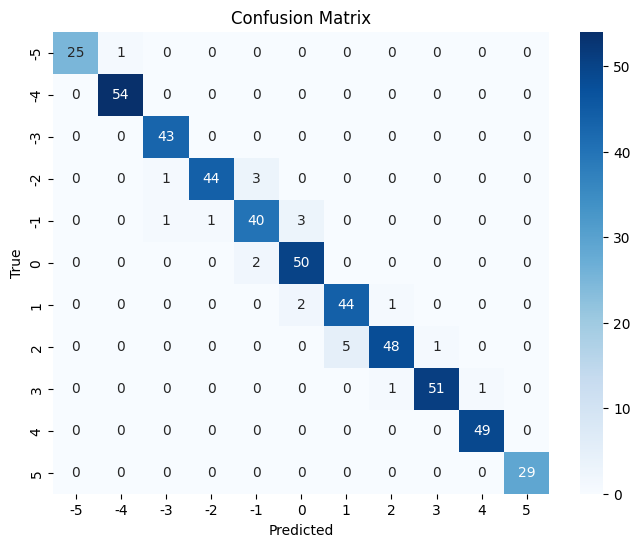

In [15]:
# Create a confusion matrix
cm = confusion_matrix(np.round(np.array(labels)), np.round((format_pred)))

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], yticklabels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



#Calculate precision, recall, and F1 score
precision = precision_score(np.round(np.array(labels)), np.round(format_pred), average='weighted')
recall = recall_score(np.round(np.array(labels)), np.round(format_pred), average='weighted')
f1 = f1_score(np.round(np.array(labels)), np.round(format_pred), average='weighted')
accuracy = accuracy_score(np.round(np.array(labels)), np.round(format_pred))

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.9547159643531072
Recall: 0.954
F1 Score: 0.9539104963144102
Accuracy: 0.954


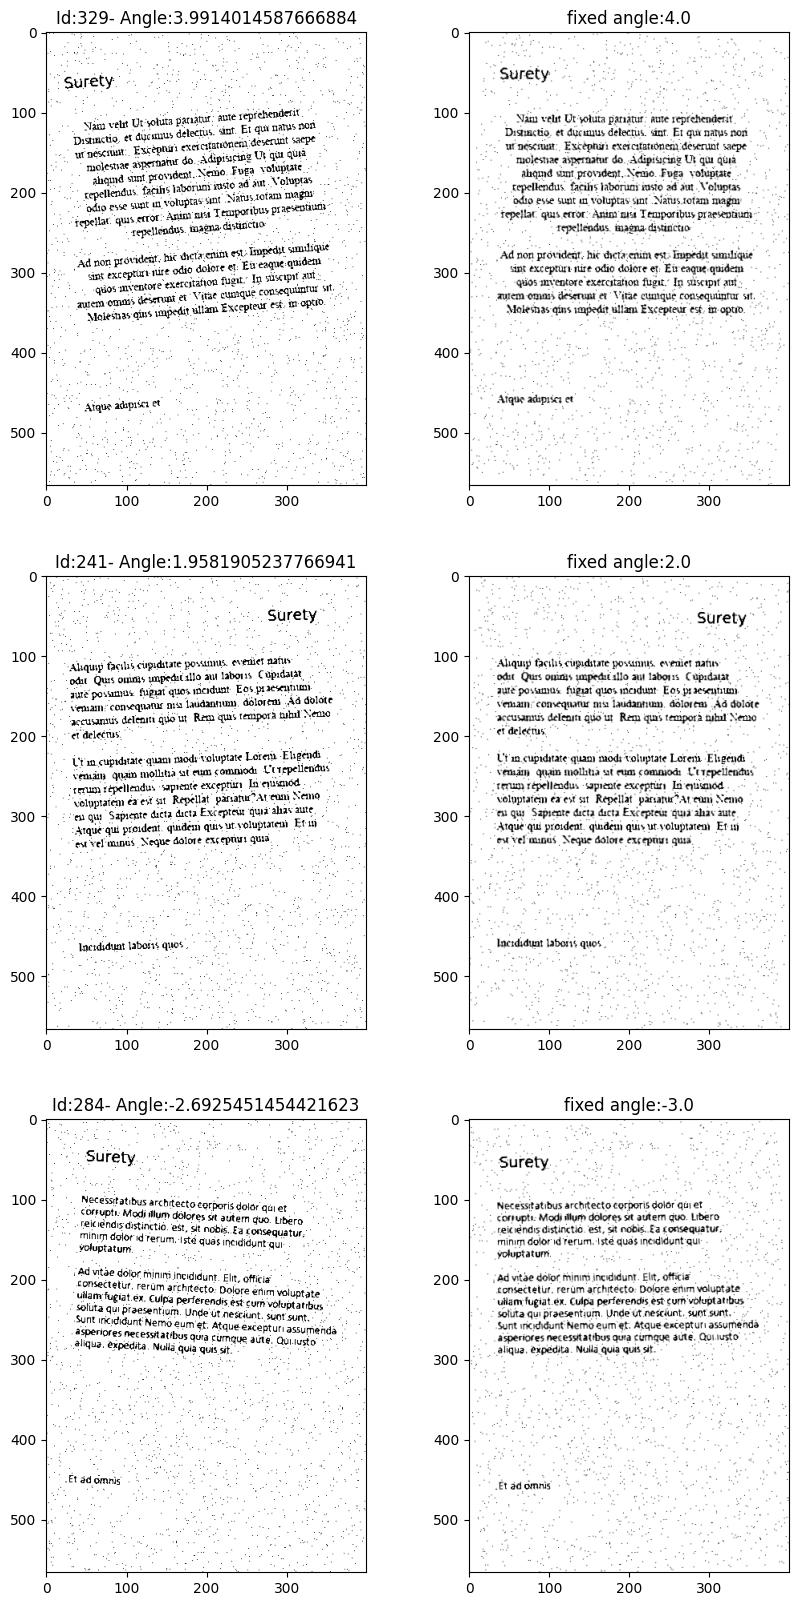

In [22]:
# Display random images
plt.figure(figsize=(10,20))
for i in range(1,7,2):
  id, sample_image_path, sample_label_path = SkewCV.get_random_img(image_paths, label_paths, train_list, label_list)

  # writes id and angle of sample in output
  with open(sample_label_path) as f:
    angle = f.read()

  sample_tile = "Id:" + str(id) + '- Angle:' + angle

  ax = plt.subplot(3, 2, i)
  image, title = SkewCV.display_image(sample_image_path, sample_tile)
  plt.imshow(image, cmap='gray');
  plt.title(title)

  ax = plt.subplot(3, 2, i+1)
  corrected_image, title = SkewCV.display_corrected_img(sample_image_path, 'fixed angle:' + str((90 - pred[id])), -(90 -pred[id]) )
  plt.imshow(corrected_image);
  plt.title(title)

### Load CSV from the folder

In [23]:
# Load CSV file data into dataframe
def load_csv(location):
  csv_file_path = os.path.join(location, csv_file_name)

  # Read the CSV file into a DataFrame
  df = pd.read_csv(csv_file_path)

  return df


## Tilted Dataset for Verifiction

In [ ]:
# Load CSV file data into dataframe from the tilted images database
tilted_input_data = load_csv(tilted_image_paths)

In [ ]:
tilted_input_data.head(5)

FILE_NAME TYPE  VALUE
0  scan_000.png    T   -0.2
1  scan_001.png    T   -0.2
2  scan_002.png    T    0.0
3  scan_003.png    T   -0.1
4  scan_004.png    T   -0.1

### Load few random image from tilted training dataset

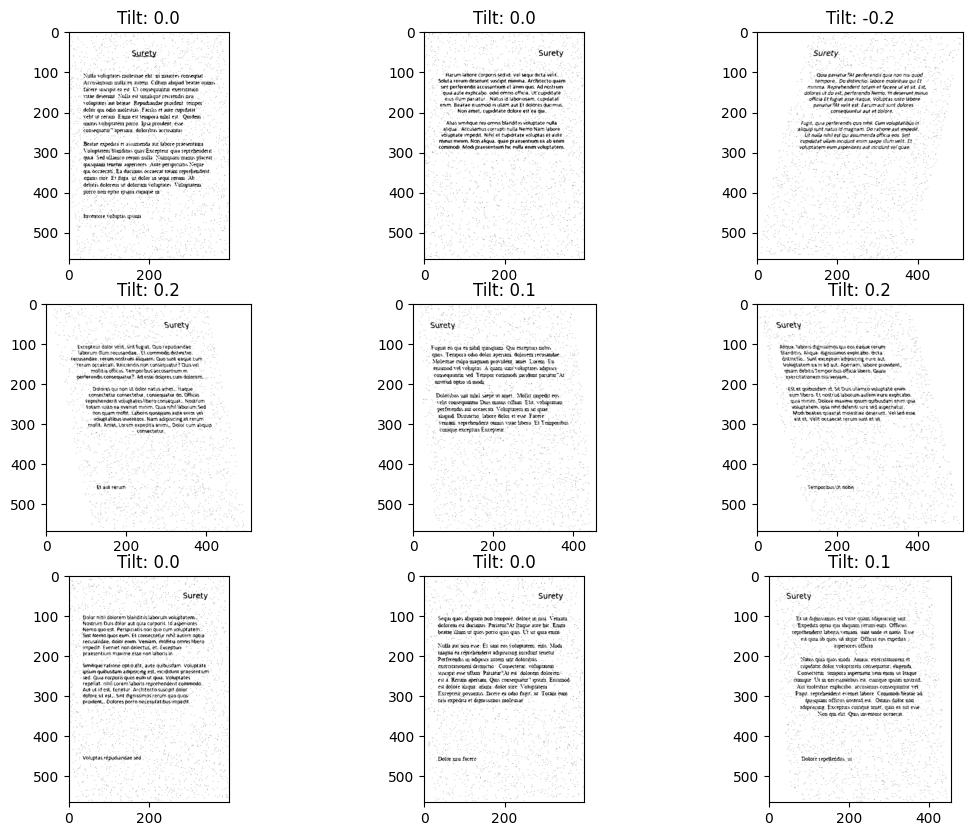

In [ ]:
# Display random images
plt.figure(figsize=(13,10))
for i in range(9):
  id, sample_image_path, sample_label = SkewCV.get_random_cd_img(tilted_image_paths, tilted_input_data, [0, len(tilted_input_data)])

  sample_tile = sample_label

  ax = plt.subplot(3, 3, i+1)
  image, title = SkewCV.display_image(sample_image_path, sample_tile)
  plt.imshow(image)
  plt.title(title)

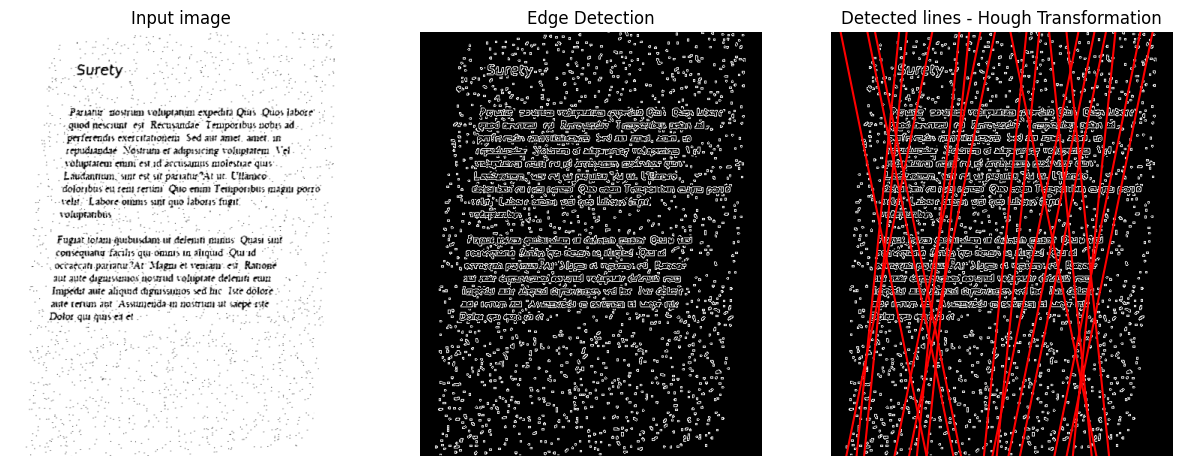

Predicted Angle 0.2, fixed angle 0.2
Original Angle: Tilt: -0.1


In [ ]:
# If Selected dataset got skewed and tilted images, run this code segment till you find skewed image
# Function is not intelligent provide skewed image. It is design to return 1 instance randomly from dataset.
id, sample_image_path, sample_label = SkewCV.get_random_cd_img(tilted_image_paths, tilted_input_data, [100, 100])

image, edges, y, angle, fixed_angle = SkewCV.display_Hough_Transform_tilt(sample_image_path, shear_values)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()


ax[1].imshow(edges, cmap="gray")
ax[1].set_title('Edge Detection')
ax[1].set_axis_off()

ax[2].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for y0, y1  in y:
  ax[2].plot(origin, (y0, y1), '-r')

ax[2].set_xlim(origin)
ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines - Hough Transformation')
plt.show()


print(f"Predicted Angle {angle}, fixed angle {fixed_angle:.2}")
print(f"Original Angle: {sample_label}")

Text(0.5, 1.0, 'fixed angle:0.2')

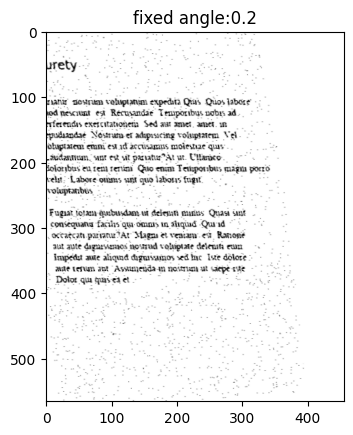

In [ ]:
corrected_image, title = SkewCV.display_corrected_tilt_img(sample_image_path, 'fixed angle:' + str(round(fixed_angle,2)), fixed_angle )
plt.imshow(corrected_image);
plt.title(title)

In [ ]:
# Create Data Structure to hold Predicted values
tilted_predict_date = tilted_input_data.copy()

#Add 2 coloumns
tilted_predict_date['PRED'] = 0.0 # Polulate with 0.0 for Normal Images
tilted_predict_date['PRED_TYPE'] = 'T' # Polulate with 'N' for Normal Images

In [ ]:
tilted_predict_date.head(5)

FILE_NAME TYPE  VALUE  PRED PRED_TYPE
0  scan_000.png    T   -0.2   0.0         T
1  scan_001.png    T   -0.2   0.0         T
2  scan_002.png    T    0.0   0.0         T
3  scan_003.png    T   -0.1   0.0         T
4  scan_004.png    T   -0.1   0.0         T

In [ ]:
# Predict Angle for input dataset
for row in tilted_predict_date.itertuples():
  img = imread(os.path.join(tilted_image_paths ,row.FILE_NAME))

  # Tilt Correction
  angle, fixed_angle = SkewCV.cd_Hough_Transform_tilt(img, shear_values)

  # Update Data
  if abs(round(fixed_angle,2)) > 0.00 and abs(round(fixed_angle,2)) <= 0.20:
    tilted_predict_date.at[row.Index, 'PRED'] = - round(fixed_angle,2)
    tilted_predict_date.at[row.Index, 'PRED_TYPE'] = 'T'

In [ ]:
tilted_predict_date.head(5)

FILE_NAME TYPE  VALUE  PRED PRED_TYPE
0  scan_000.png    T   -0.2  -0.2         T
1  scan_001.png    T   -0.2  -0.1         T
2  scan_002.png    T    0.0  -0.2         T
3  scan_003.png    T   -0.1  -0.1         T
4  scan_004.png    T   -0.1  -0.1         T

In [ ]:
# Compute mean square error over all the labels
np.sum(np.square(tilted_predict_date['VALUE'] - tilted_predict_date['PRED']))/len(tilted_predict_date)

0.02370000000000001

In [ ]:
np.sum(np.square(np.round(tilted_predict_date['VALUE'],2) - np.round(tilted_predict_date['PRED'],2)))/len(tilted_predict_date)

0.02370000000000001

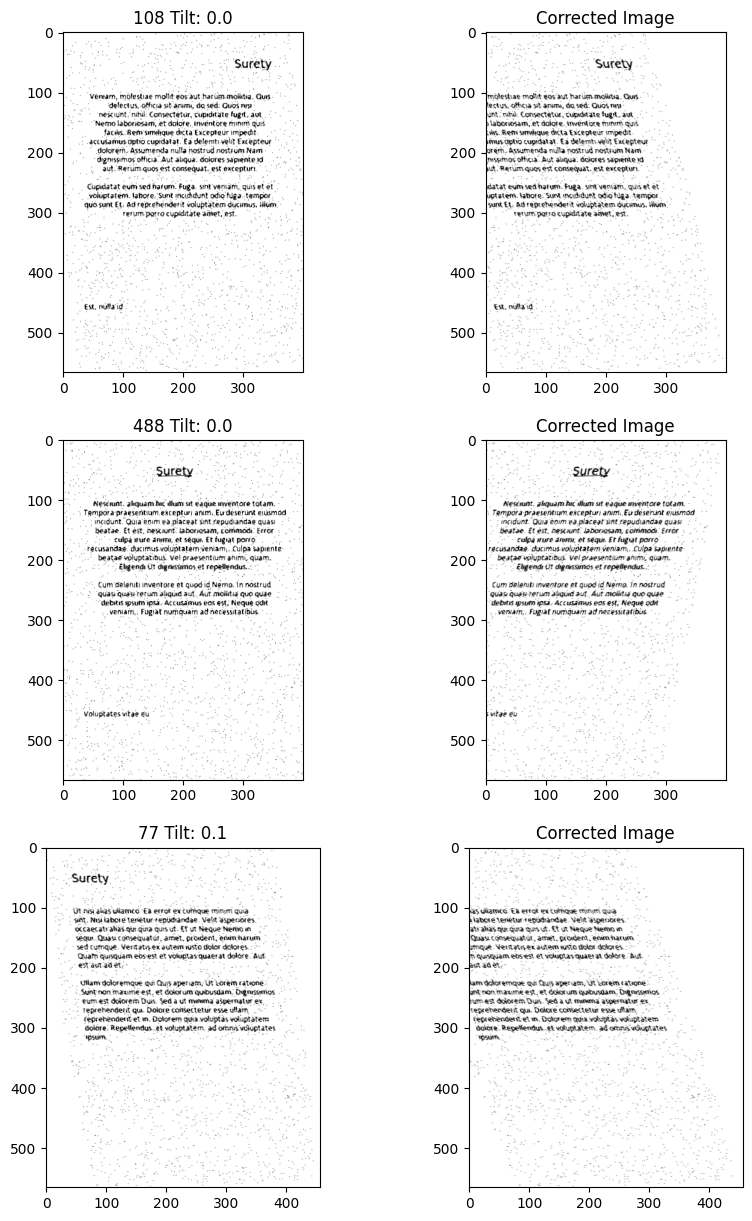

In [ ]:
# Display random images
plt.figure(figsize=(10,15))
for i in range(1,7,2):
  id, sample_image_path, sample_label = SkewCV.get_random_cd_img(tilted_image_paths, tilted_input_data, [0, len(tilted_predict_date)])

  sample_title = str(id) + ' '+ sample_label
  if sample_image_path is not None:
     img = imread(sample_image_path)

  ax = plt.subplot(3, 2, i)
  plt.imshow(img);
  plt.title(sample_title)
  ax = plt.subplot(3, 2, i+1)
  if tilted_predict_date.loc[id, 'PRED_TYPE'] == 'S':
    img_corrected = SkewCV.cd_skewness_correction(img, angle_range, 1.0, 0.1)
  elif tilted_predict_date.loc[id, 'PRED_TYPE'] == 'T':
    img_corrected = SkewCV.cd_tilt_correction(img, shear_values)
  else: img_corrected = img
  plt.imshow(img_corrected);
  plt.title('Corrected Image')

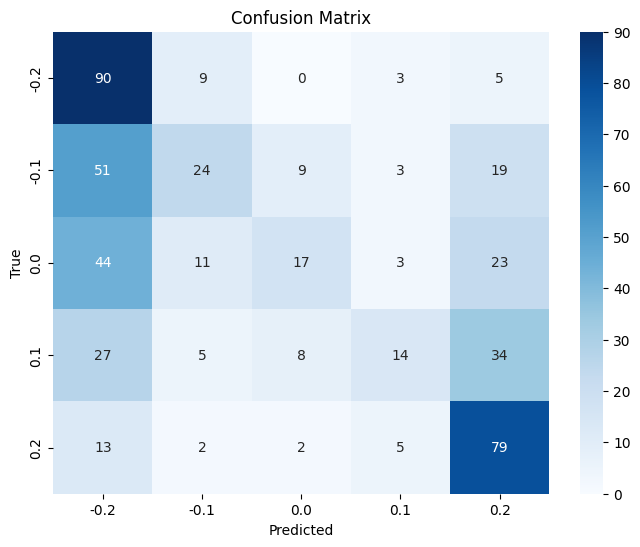

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(tilted_predict_date['VALUE'] * 10, tilted_predict_date['PRED'] * 10)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-0.2,-0.1,0.0,0.1,0.2], yticklabels=[-0.2,-0.1,0.0,0.1,0.2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [24]:
# Load CSV file data into dataframe from the tilted images database
tilted_T_input_data = load_csv(tilted_T_image_paths)

In [25]:
tilted_T_input_data.head(5)

FILE_NAME TYPE  VALUE
0  scan_000.png    T   -0.2
1  scan_001.png    T   -0.2
2  scan_002.png    T    0.0
3  scan_003.png    T   -0.1
4  scan_004.png    T   -0.1

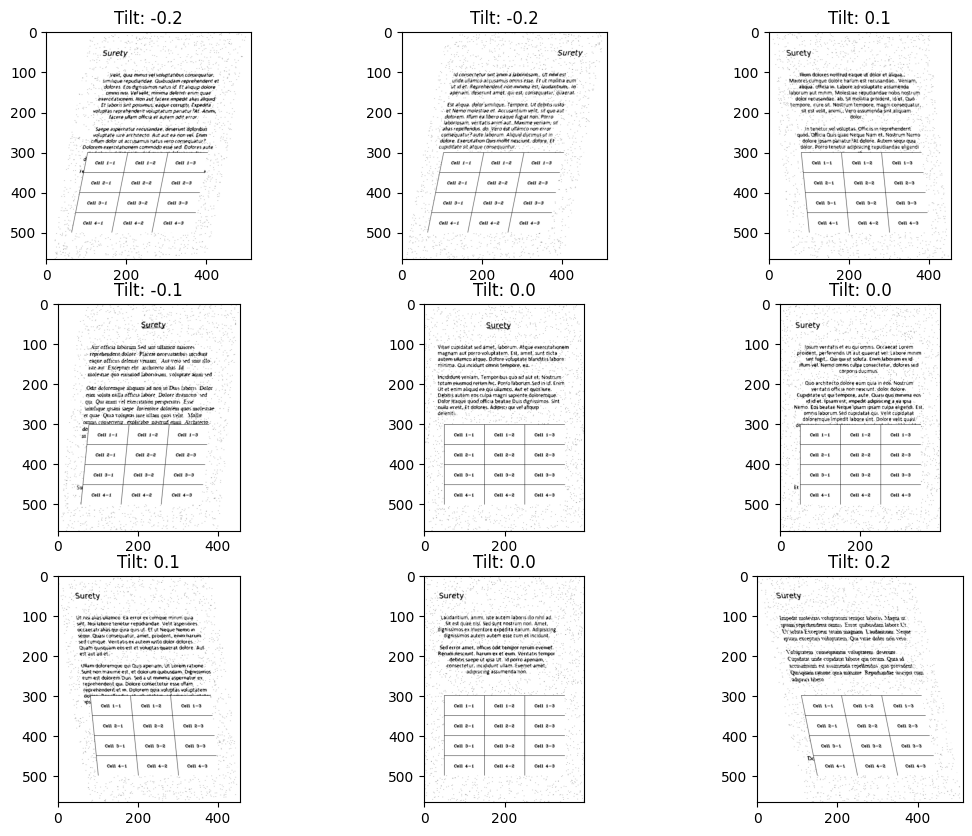

In [23]:
# Display random images
plt.figure(figsize=(13,10))
for i in range(9):
  id, sample_image_path, sample_label = SkewCV.get_random_cd_img(tilted_T_image_paths, tilted_T_input_data, [0, len(tilted_T_input_data)])

  sample_tile = sample_label

  ax = plt.subplot(3, 3, i+1)
  image, title = SkewCV.display_image(sample_image_path, sample_tile)
  plt.imshow(image)
  plt.title(title)

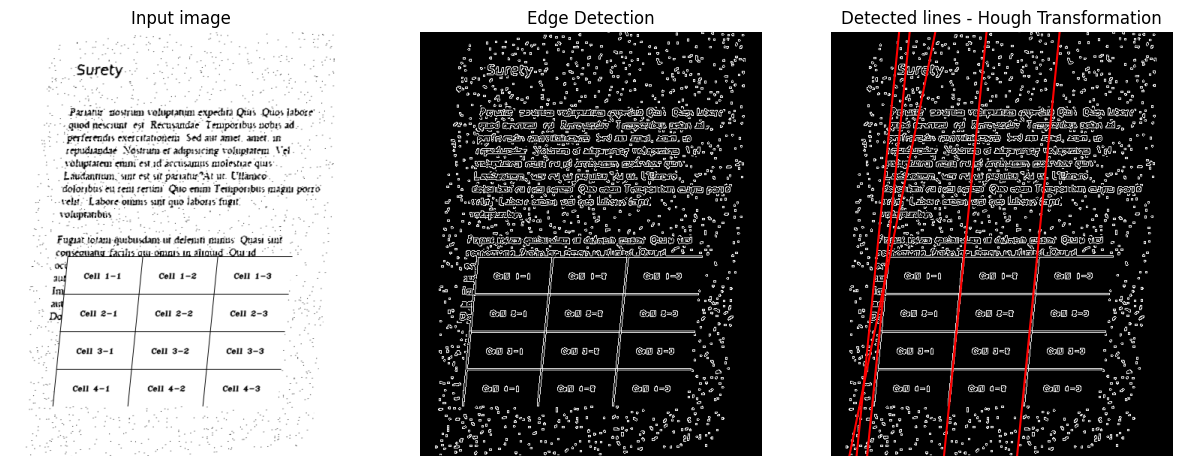

Predicted Angle 0.1, fixed angle 0.1
Original Angle: Tilt: -0.1


In [24]:
# If Selected dataset got skewed and tilted images, run this code segment till you find skewed image
# Function is not intelligent provide skewed image. It is design to return 1 instance randomly from dataset.
id, sample_image_path, sample_label = SkewCV.get_random_cd_img(tilted_T_image_paths, tilted_T_input_data, [100, 100])

image, edges, y, angle, fixed_angle = SkewCV.display_Hough_Transform_tilt(sample_image_path, shear_values)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()


ax[1].imshow(edges, cmap="gray")
ax[1].set_title('Edge Detection')
ax[1].set_axis_off()

ax[2].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for y0, y1  in y:
  ax[2].plot(origin, (y0, y1), '-r')

ax[2].set_xlim(origin)
ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines - Hough Transformation')
plt.show()


print(f"Predicted Angle {angle}, fixed angle {fixed_angle:.2}")
print(f"Original Angle: {sample_label}")

Text(0.5, 1.0, 'fixed angle:0.1')

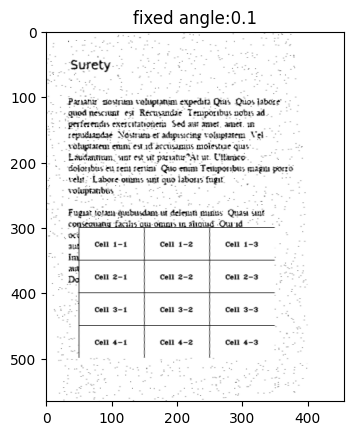

In [25]:
corrected_image, title = SkewCV.display_corrected_tilt_img(sample_image_path, 'fixed angle:' + str(round(fixed_angle,2)), fixed_angle )
plt.imshow(corrected_image);
plt.title(title)

In [26]:
# Create Data Structure to hold Predicted values
tilted_T_predict_date = tilted_T_input_data.copy()

#Add 2 coloumns
tilted_T_predict_date['PRED'] = 0.0 # Polulate with 0.0 for Normal Images
tilted_T_predict_date['PRED_TYPE'] = 'T' # Polulate with 'N' for Normal Images

In [27]:
tilted_T_predict_date.head(5)

FILE_NAME TYPE  VALUE  PRED PRED_TYPE
0  scan_000.png    T   -0.2   0.0         T
1  scan_001.png    T   -0.2   0.0         T
2  scan_002.png    T    0.0   0.0         T
3  scan_003.png    T   -0.1   0.0         T
4  scan_004.png    T   -0.1   0.0         T

In [28]:
# Predict Angle for input dataset
for row in tilted_T_predict_date.itertuples():
  img = imread(os.path.join(tilted_T_image_paths ,row.FILE_NAME))

  # Tilt Correction
  angle, fixed_angle = SkewCV.cd_Hough_Transform_tilt(img, shear_values)

  # Update Data
  if abs(round(fixed_angle,2)) > 0.00 and abs(round(fixed_angle,2)) <= 0.20:
    tilted_T_predict_date.at[row.Index, 'PRED'] = - round(fixed_angle,2)
    tilted_T_predict_date.at[row.Index, 'PRED_TYPE'] = 'T'

In [29]:
tilted_T_predict_date.head(5)

FILE_NAME TYPE  VALUE  PRED PRED_TYPE
0  scan_000.png    T   -0.2  -0.2         T
1  scan_001.png    T   -0.2  -0.2         T
2  scan_002.png    T    0.0   0.0         T
3  scan_003.png    T   -0.1  -0.1         T
4  scan_004.png    T   -0.1  -0.1         T

In [30]:
# Compute mean square error over all the labels
np.sum(np.square(tilted_T_predict_date['VALUE'] - tilted_T_predict_date['PRED']))/len(tilted_T_predict_date)

0.0

In [31]:
np.sum(np.square(np.round(tilted_T_predict_date['VALUE'],2) - np.round(tilted_T_predict_date['PRED'],2)))/len(tilted_T_predict_date)

0.0

In [ ]:
# Display random images
plt.figure(figsize=(10,15))
for i in range(1,7,2):
  id, sample_image_path, sample_label = SkewCV.get_random_cd_img(tilted_T_image_paths, tilted_T_input_data, [0, len(tilted_T_predict_date)])

  sample_title = str(id) + ' '+ sample_label
  if sample_image_path is not None:
     img = imread(sample_image_path)

  ax = plt.subplot(3, 2, i)
  plt.imshow(img);
  plt.title(sample_title)
  ax = plt.subplot(3, 2, i+1)
  if tilted_predict_date.loc[id, 'PRED_TYPE'] == 'S':
    img_corrected = SkewCV.cd_skewness_correction(img, angle_range, 1.0, 0.1)
  elif tilted_predict_date.loc[id, 'PRED_TYPE'] == 'T':
    img_corrected = SkewCV.cd_tilt_correction(img, shear_values)
  else: img_corrected = img
  plt.imshow(img_corrected);
  plt.title('Corrected Image')

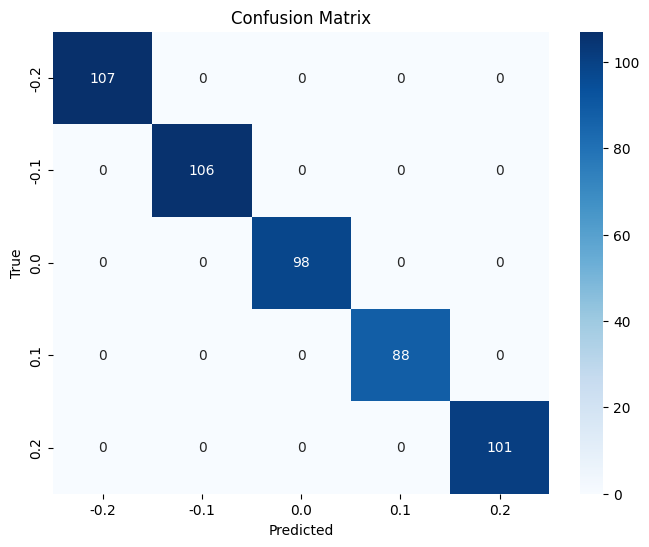

In [32]:
# Create a confusion matrix
cm = confusion_matrix(tilted_T_predict_date['VALUE'] * 10, tilted_T_predict_date['PRED'] * 10)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-0.2,-0.1,0.0,0.1,0.2], yticklabels=[-0.2,-0.1,0.0,0.1,0.2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [33]:
#Calculate precision, recall, and F1 score
precision = precision_score(tilted_T_predict_date['VALUE'] * 10, tilted_T_predict_date['PRED'] * 10, average='weighted')
recall = recall_score(tilted_T_predict_date['VALUE'] * 10, tilted_T_predict_date['PRED'] * 10, average='weighted')
f1 = f1_score(tilted_T_predict_date['VALUE'] * 10, tilted_T_predict_date['PRED'] * 10, average='weighted')
accuracy = accuracy_score(tilted_T_predict_date['VALUE'] * 10, tilted_T_predict_date['PRED'] * 10)



# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


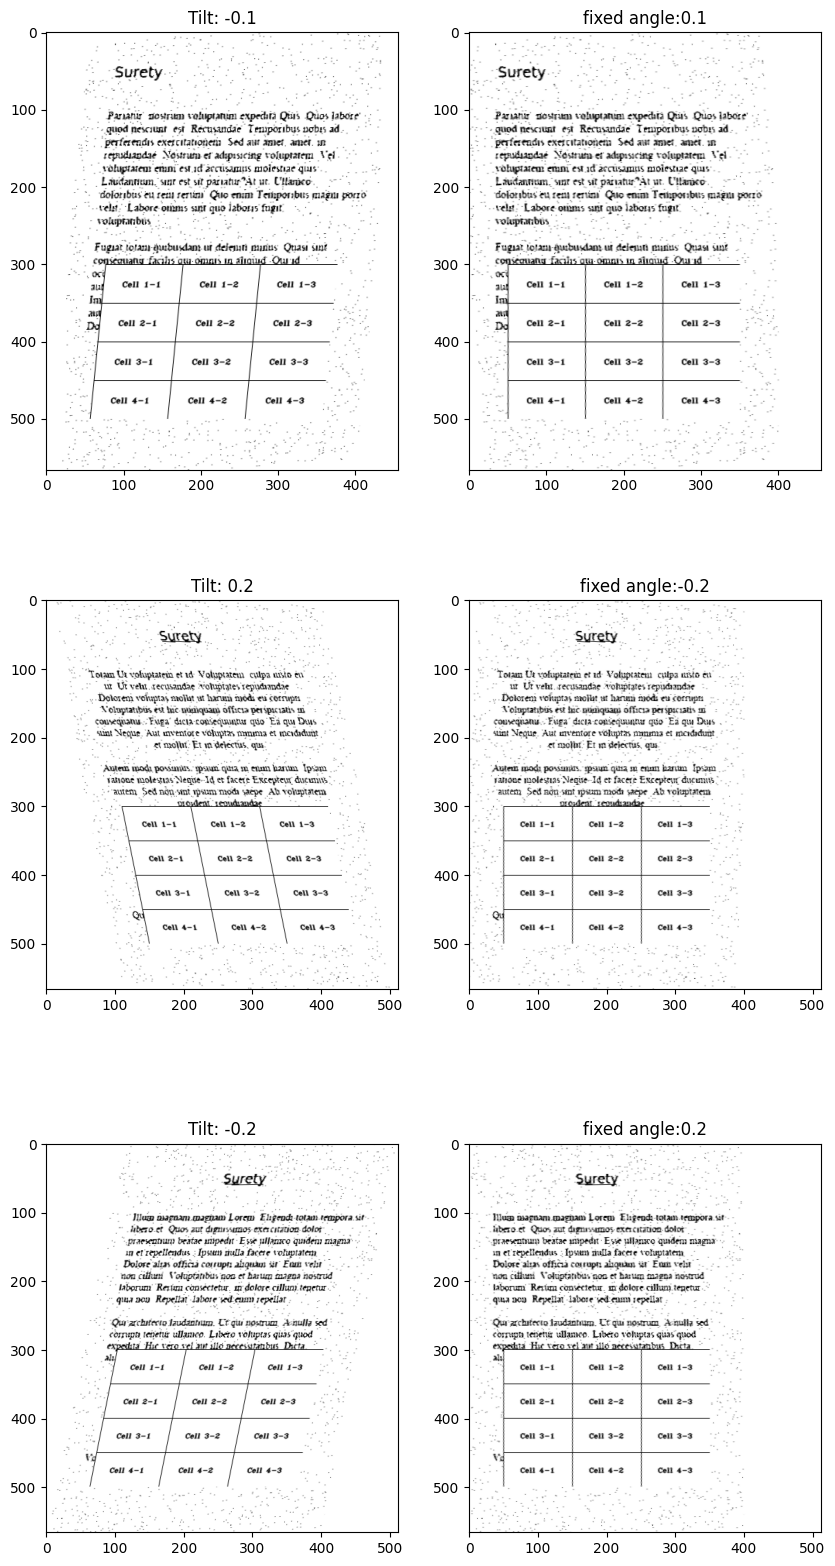

In [45]:
# Display random images
plt.figure(figsize=(10,20))
for i in range(1,7,2):
  #id, sample_image_path, sample_label_path = SkewCV.get_random_img(image_paths, label_paths, train_list, label_list)
  id, sample_image_path, sample_label = SkewCV.get_random_cd_img(tilted_T_image_paths, tilted_T_input_data, [0, len(tilted_T_input_data)])

  # writes id and angle of sample in output
  #with open(sample_label_path) as f:
    #angle = f.read()

  #sample_tile = "Id:" + str(id) + '- Angle:' + angle

  sample_tile = sample_label


  ax = plt.subplot(3, 2, i)
  image, title = SkewCV.display_image(sample_image_path, sample_tile)
  plt.imshow(image, cmap='gray');
  plt.title(title)

  ax = plt.subplot(3, 2, i+1)
  image, edges, y, angle, fixed_angle = SkewCV.display_Hough_Transform_tilt(sample_image_path, shear_values)
  corrected_image, title = SkewCV.display_corrected_tilt_img(sample_image_path, 'fixed angle:' + str(round(fixed_angle,2)), fixed_angle )
  #corrected_image, title = SkewCV.display_corrected_img(sample_image_path, 'fixed angle:' + str((90 - pred[id])), -(90 -pred[id]) )
  plt.imshow(corrected_image);
  plt.title(title)

## Course Descriptor


In [ ]:
# Global Section to hold
# 1. Dataset location  - location
# 2. Labels - cd_input_data

location_ref = int(input("Enter 1 for \'input\' folder, 2 for \'tmp_skewed\' folder or 3 for \'tmp_tilt\' folder: "))

match location_ref:
  case 1:
    location = input_path
  case 2:
    location = tmp_skewed_path
  case 3:
    location = tmp_tilt_path

cd_input_data = load_csv(location)

Enter 1 for 'input' folder, 2 for 'tmp_skewed' folder or 3 for 'tmp_tilt' folder: 1


### Load few random image from training dataset

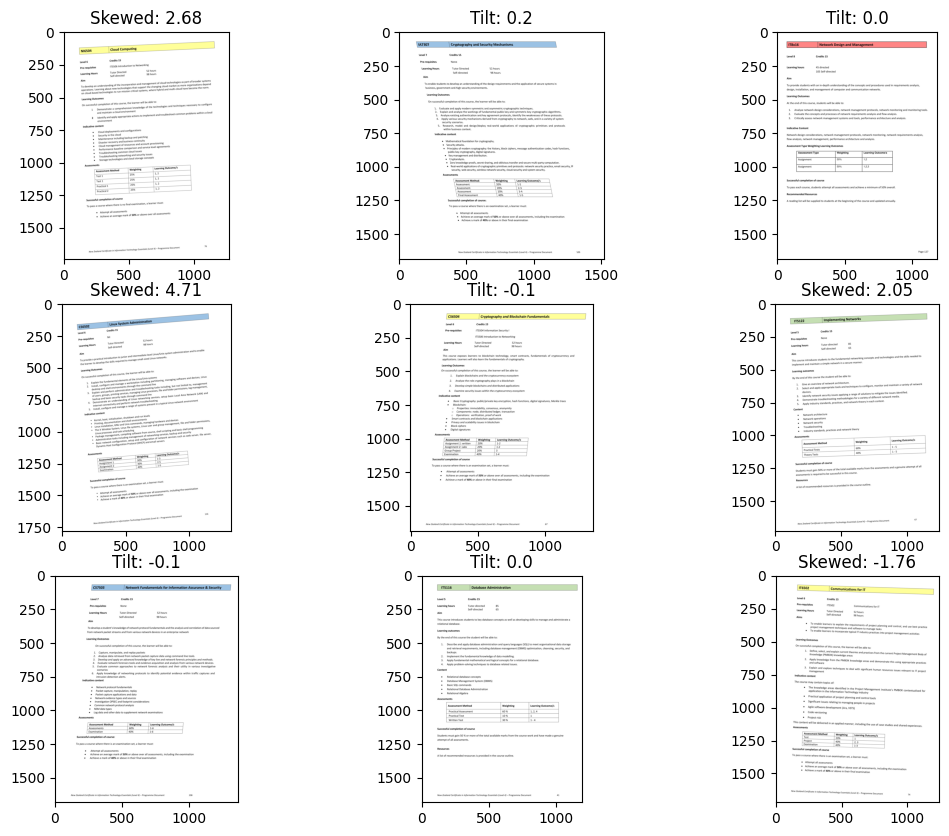

In [ ]:
# Display random images
plt.figure(figsize=(13,10))
for i in range(9):
  id, sample_image_path, sample_label = SkewCV.get_random_cd_img(location, cd_input_data, [0, len(cd_input_data)])

  sample_tile = sample_label

  ax = plt.subplot(3, 3, i+1)
  image, title = SkewCV.display_image(sample_image_path, sample_tile)
  plt.imshow(image)
  plt.title(title)

### Visualise Edge Detection and Hough Transformation on CD

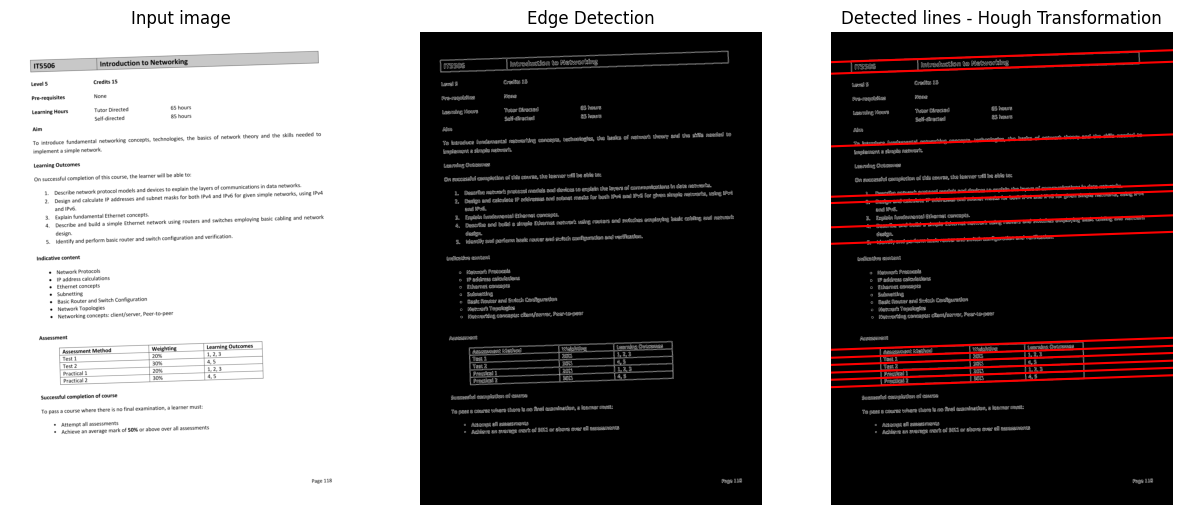

Predicted Angle 88.0, fixed angle -2.0
Original Angle: Skewed: 1.8


In [ ]:
# If Selected dataset got skewed and tilted images, run this code segment till you find skewed image
# Function is not intelligent provide skewed image. It is design to return 1 instance randomly from dataset.
id, sample_image_path, sample_label = SkewCV.get_random_cd_img(location, cd_input_data,[78, 78])

image, edges, y, cd_angle, cd_fixed_angle = SkewCV.display_Hough_Transform(sample_image_path, angle_range, 1.0)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()


ax[1].imshow(edges, cmap="gray")
ax[1].set_title('Edge Detection')
ax[1].set_axis_off()

ax[2].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for y0, y1  in y:
  ax[2].plot(origin, (y0, y1), '-r')

ax[2].set_xlim(origin)
ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines - Hough Transformation')
plt.show()


print(f"Predicted Angle {cd_angle}, fixed angle {cd_fixed_angle:.2}")
print(f"Original Angle: {sample_label}")

Text(0.5, 1.0, 'fixed angle:-2.0')

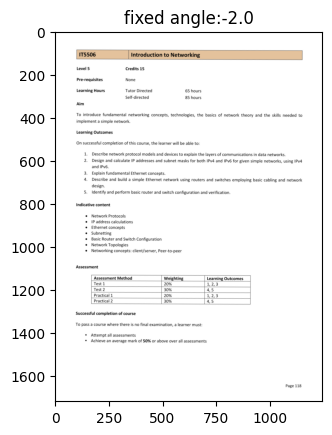

In [ ]:
corrected_img, title = SkewCV.display_corrected_img(sample_image_path, 'fixed angle:' + str(cd_fixed_angle), cd_fixed_angle )

#plt.imshow(corrected_image, cmap='gray');
plt.imshow(corrected_img);
plt.title(title)

## Section for Working with Tilt Correction

Predicted Angle 0.1, fixed angle 0.1
Original Angle: Tilt: -0.1


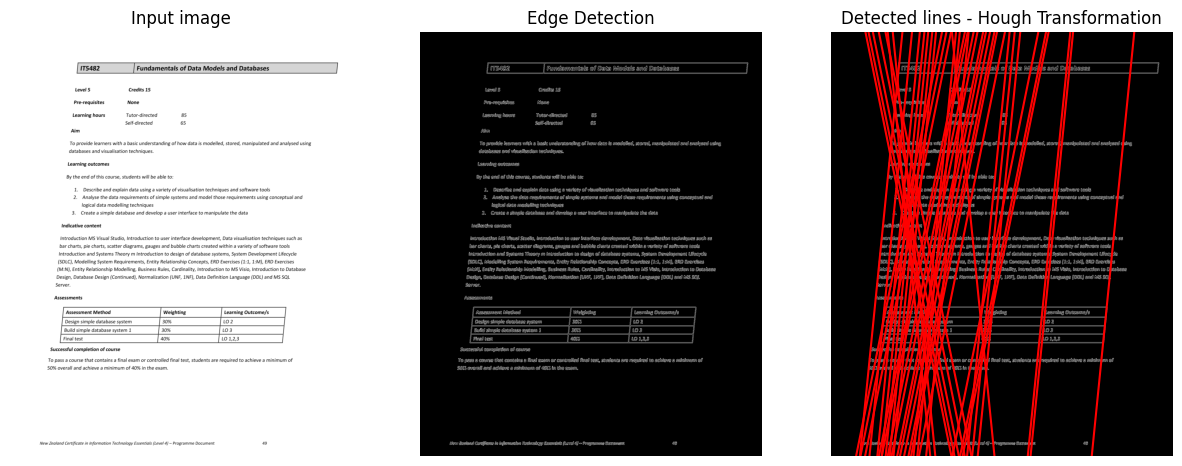

Predicted Angle 0.1, fixed angle 0.1
Original Angle: Tilt: -0.1


In [ ]:
# Same as skewed example, run this function till you find tilted image example
id, sample_image_path, sample_label = SkewCV.get_random_cd_img(location, cd_input_data,[9, 9])

image, edges, y, cd_angle, cd_fixed_angle = SkewCV.display_Hough_Transform_tilt(sample_image_path, shear_values)
print(f"Predicted Angle {cd_angle}, fixed angle {cd_fixed_angle:.2}")
print(f"Original Angle: {sample_label}")

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()


ax[1].imshow(edges, cmap="gray")
ax[1].set_title('Edge Detection')
ax[1].set_axis_off()

ax[2].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for y0, y1  in y:
  ax[2].plot(origin, (y0, y1), '-r')

ax[2].set_xlim(origin)
ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines - Hough Transformation')
plt.show()


print(f"Predicted Angle {cd_angle}, fixed angle {cd_fixed_angle:.2}")
print(f"Original Angle: {sample_label}")

Text(0.5, 1.0, 'fixed angle:0.1')

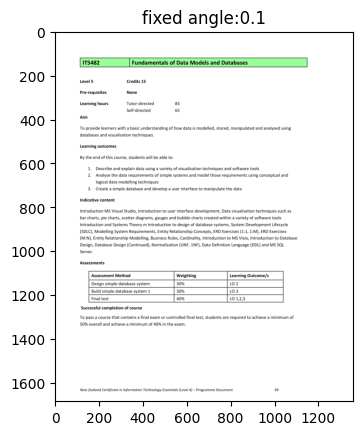

In [ ]:
corrected_image, title = SkewCV.display_corrected_tilt_img(sample_image_path, 'fixed angle:' + str(round(cd_fixed_angle,2)), cd_fixed_angle )
plt.imshow(corrected_image);
plt.title(title)

In [ ]:
# Create Data Structure to hold Predicted values
cd_predict_date = cd_input_data.copy()

#Add 2 coloumns
cd_predict_date['PRED'] = 0.0 # Polulate with 0.0 for Normal Images
cd_predict_date['PRED_TYPE'] = 'N' # Polulate with 'N' for Normal Images

In [ ]:
cd_predict_date.head(5)

FILE_NAME TYPE  VALUE  PRED PRED_TYPE
0   page_40    S  -4.21   0.0         N
1   page_41    T   0.00   0.0         N
2   page_42    S   3.29   0.0         N
3   page_43    N   0.00   0.0         N
4   page_44    S   1.19   0.0         N

In [ ]:
# Predict Angle for input dataset
for row in cd_predict_date.itertuples():
  img = imread(os.path.join(location ,f'{row.FILE_NAME}.png'))

  # Skewness Correction
  angle, fixed_angle = SkewCV.cd_Hough_Transform(img, angle_range, 1.0, 0.1)

  # Update Data
  if abs(round(fixed_angle,1)) > 0.0 and abs(round(fixed_angle,1)) <= 5.0:
    cd_predict_date.at[row.Index, 'PRED'] = - round(fixed_angle,2)
    cd_predict_date.at[row.Index, 'PRED_TYPE'] = 'S'
    #img = cd_skewness_correction(img)
  else:
    # Tilt Correction
    angle, fixed_angle = SkewCV.cd_Hough_Transform_tilt(img, shear_values)

    # Update Data
    if abs(round(fixed_angle,2)) > 0.00 and abs(round(fixed_angle,2)) <= 0.20:
      cd_predict_date.at[row.Index, 'PRED'] = - round(fixed_angle,2)
      cd_predict_date.at[row.Index, 'PRED_TYPE'] = 'T'


In [ ]:
#cd_predict_date.head(5)
cd_predict_date[45:60]

FILE_NAME TYPE  VALUE  PRED PRED_TYPE
45   page_85    S  -2.87  -2.9         S
46   page_86    T   0.10   0.1         T
47   page_87    T   0.10  -0.2         T
48   page_88    T   0.10  -0.2         T
49   page_89    T  -0.10  -0.2         T
50   page_90    T   0.00   0.0         N
51   page_91    S  -3.60  -3.6         S
52   page_92    T   0.20   0.2         T
53   page_93    T   0.20   0.2         T
54   page_94    T   0.00   0.0         N
55   page_95    S   2.47   2.5         S
56   page_96    T   0.10  -0.2         T
57   page_97    S   3.98   4.0         S
58   page_98    T   0.10  -0.2         T
59   page_99    S  -1.38  -1.4         S

In [ ]:
cd_predict_date[cd_predict_date['TYPE'] != cd_predict_date['PRED_TYPE']]

FILE_NAME TYPE  VALUE  PRED PRED_TYPE
1    page_41    T    0.0   0.0         N
3    page_43    N    0.0  -0.2         T
19   page_59    T    0.0   0.0         N
22   page_62    T    0.0   0.0         N
40   page_80    T    0.0   0.0         N
44   page_84    T    0.0   0.0         N
50   page_90    T    0.0   0.0         N
54   page_94    T    0.0   0.0         N
73  page_113    T    0.1   0.0         N
75  page_115    T    0.0   0.0         N
83  page_124    T    0.0   0.0         N
86  page_127    T    0.0   0.0         N

In [ ]:
# Compute mean square error over all the labels
np.sum(np.square(cd_predict_date['VALUE'] - cd_predict_date['PRED']))/len(cd_predict_date)

0.007353333333333337

In [ ]:
np.sum(np.square(np.round(cd_predict_date['VALUE'],2) - np.round(cd_predict_date['PRED'],2)))/len(cd_predict_date)

0.007353333333333337

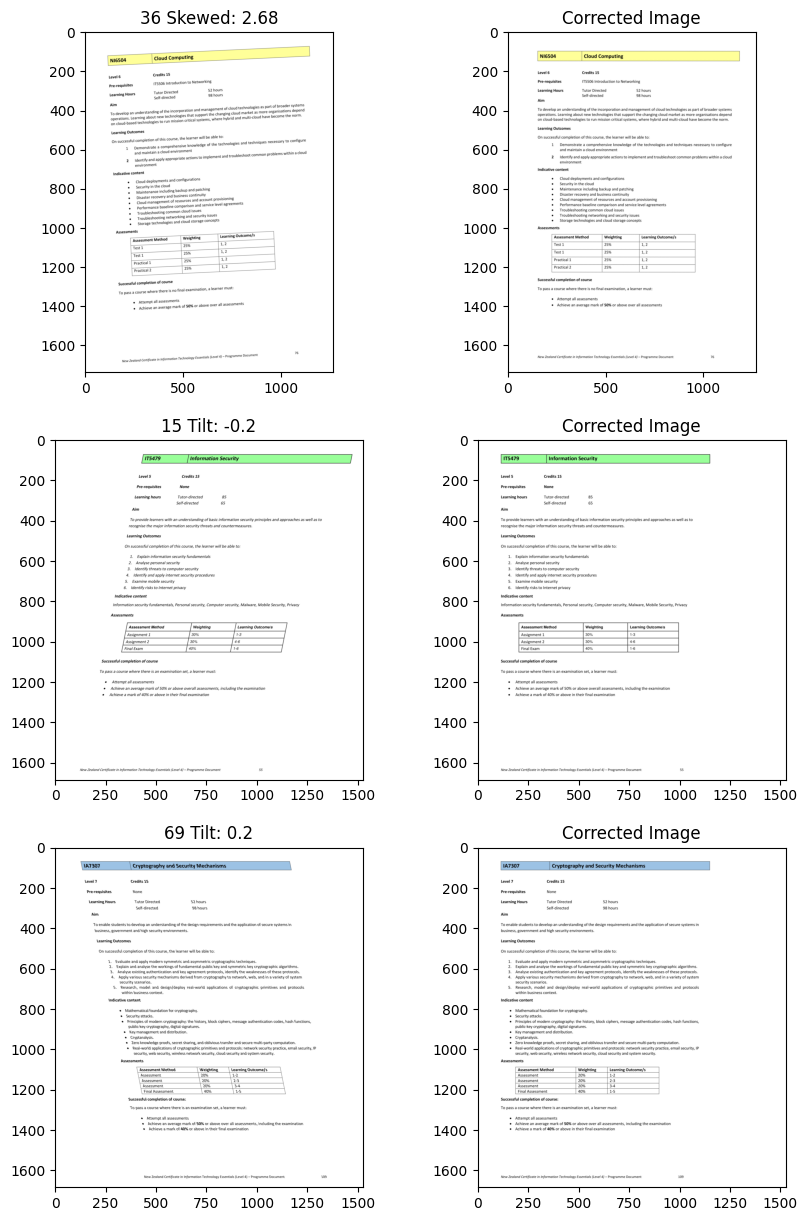

In [ ]:
# Display random images
plt.figure(figsize=(10,15))
for i in range(1,7,2):
  id, sample_image_path, sample_label = SkewCV.get_random_cd_img(location, cd_input_data, [0, len(cd_predict_date)])

  sample_title = str(id) + ' '+ sample_label
  if sample_image_path is not None:
     img = imread(sample_image_path)

  ax = plt.subplot(3, 2, i)
  plt.imshow(img);
  plt.title(sample_title)
  ax = plt.subplot(3, 2, i+1)
  if cd_predict_date.loc[id, 'PRED_TYPE'] == 'S':
    img_corrected = SkewCV.cd_skewness_correction(img, angle_range, 1.0, 0.1)
  elif cd_predict_date.loc[id, 'PRED_TYPE'] == 'T':
    img_corrected = SkewCV.cd_tilt_correction(img, shear_values)
  else: img_corrected = img
  plt.imshow(img_corrected);
  plt.title('Corrected Image')

